In [244]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [245]:
words = []
import csv
with open('arabic_names.csv', 'r') as f:
    csv_reader = csv.reader(f, delimiter=',')
    for row in csv_reader:
        words.append(row[0].strip())
del words[0]

In [246]:
len(words)

1405

In [247]:
 # building the vocabulary and mapping
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}

In [248]:
block_size = 3

X, Y = [], []

for w in words:
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '------>', itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)


In [249]:
X.shape, X.dtype, Y.shape, Y.dtype


(torch.Size([7646, 3]), torch.int64, torch.Size([7646]), torch.int64)

In [250]:
# Build a data set

def built_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(56)
random.shuffle(words)
n1 = int(0.8* len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = built_dataset(words[:n1])
Xdev, Ydev = built_dataset(words[n1:n2])
Xte, Yte = built_dataset(words[n2:])


torch.Size([6135, 3]) torch.Size([6135])
torch.Size([750, 3]) torch.Size([750])
torch.Size([761, 3]) torch.Size([761])


In [278]:
g = torch.Generator().manual_seed(123456789)

C = torch.randn((38, 5), generator=g)
W1 = torch.randn((15, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 38), generator=g)
b2 = torch.rand(38, generator=g)
params = [C, W1, b1, W2, b2]

In [279]:
sum(p.nelement() for p in params)

11028

In [280]:
for p in params:
    p.requires_grad = True


In [281]:
stepi = []
lossi = []

In [298]:
for i in range(5000):
    # minibatching
    ix = torch.randint(0, Xtr.shape[0], (32,))
    # Forward pass
    emb = C[Xtr[ix]] # (14, 3, 2)
    h = torch.tanh(emb.view(-1, 15) @ W1 + b1) # (14, 100)
    logit = h @ W2 + b2 # (14, 38
    loss = F.cross_entropy(logit, Ytr[ix])
    # print(loss.item())
    # backward pass
    for p in params:
        p.grad = None
    loss.backward()

    # update the learning rate to find the optimum one
    lr = 0.01
    for p in params:
        p.data += -lr * p.grad

    # track stats
    stepi.append(i)
    lossi.append(loss.log10().item())



print(loss.item())


1.890907883644104


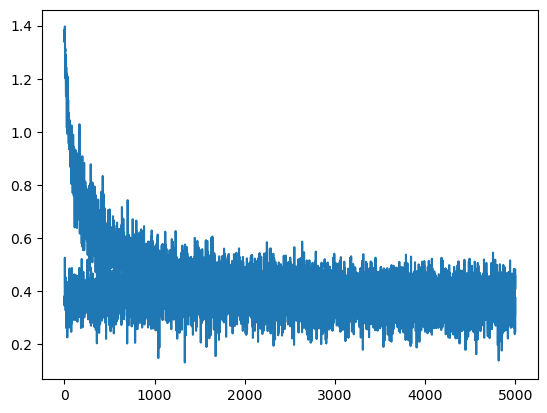

In [286]:
plt.plot(stepi, lossi)

In [299]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 15) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0242, grad_fn=<NllLossBackward0>)

In [300]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 15) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.6097, grad_fn=<NllLossBackward0>)

In [292]:
# training split 80% , dev/validation split 10% , text split 10%

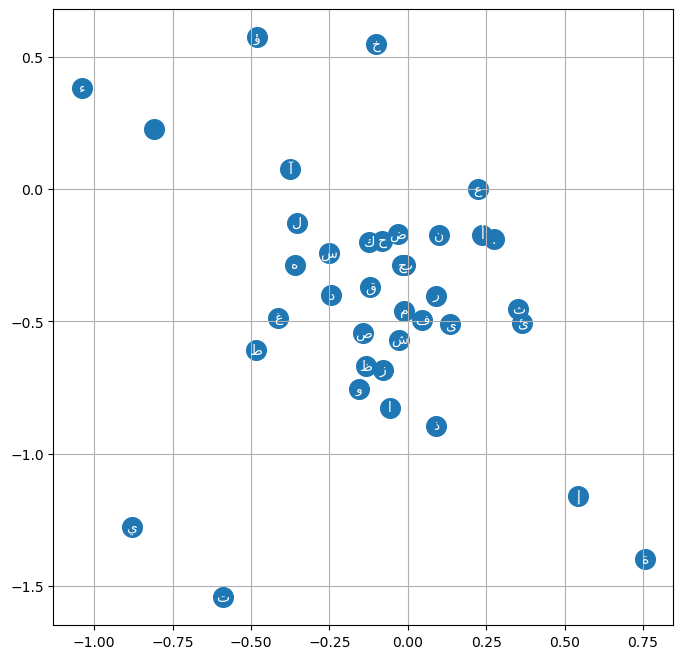

In [297]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

In [301]:
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))



شيد.
عواهدة.
شقية.
مادرة.
رند.
جاهرة.
نفيقة.
دان.
عزيز.
حاري.
عويتا.
عتماري.
ضهادة.
مليم.
حمى.
هلاء.
ناود.
حام.
نجعة.
ممرسب.


In [306]:
'مليم' in words

False